In [1]:
import copy
import matplotlib.pyplot as plt
from math import cos
import warnings
warnings.filterwarnings('ignore')
import parser
import numpy as np



## Модуль интерполяции сплайнами

In [2]:
class CubicSplineInterpolator:
    def __init__(self, xGrid, fGrid, sppa=0, sppb=0):

        self.sppa = sppa
        self.sppb = sppb
        self.xGrid = xGrid
        self.fGrid = fGrid
        self.N = len(xGrid)
        self.coeffs = self.ComputeCoefficients(xGrid, fGrid)

    def create_matrix(self, hGrid, yGrid):
        A = np.zeros((self.N, self.N))
        b = np.zeros((self.N, 1))
        b[0][0] = self.sppa
        A[0, 0] = 1
        A[-1, -1] = 1

        for i in range(1, self.N - 1):
            A[i, i - 1] = hGrid[i - 1]
            A[i, i + 1] = hGrid[i]
            A[i, i] = 2 * (hGrid[i - 1] + hGrid[i])
            b[i, 0] = 3 * (yGrid[i] / hGrid[i] - yGrid[i - 1] / hGrid[i - 1])

        return A, b

    def solve_matrix(self, A, b):
        alphas = np.zeros(self.N)
        betas = np.zeros(self.N)

        alphas[0] = A[0, 1] / A[0, 0]
        betas[0] = b[0][0] / A[0, 0]

        for i in range(1, self.N - 1):
            alphas[i] = A[i, i + 1] / (A[i, i] - A[i, i - 1] * alphas[i - 1])
            betas[i] = (b[i][0] - A[i, i - 1] * betas[i - 1]) / (
                A[i, i] - A[i, i - 1] * alphas[i - 1])

        coefs = np.zeros(self.N)
        coefs[self.N - 1] = self.sppb

        for i in range(self.N - 2, -1, -1):
            coefs[i] = betas[i] - alphas[i] * coefs[i + 1]

        return coefs

    def ComputeCoefficients(self, xGrid, fGrid):
        coefs = np.array([])

        hGrid = np.array([])
        for i in range(1, len(xGrid)):
            hGrid = np.append(hGrid, xGrid[i] - xGrid[i - 1])

        coefs_A = copy.deepcopy(fGrid)[:-1]

        yGrid = np.array([])
        for i in range(1, len(fGrid)):
            yGrid = np.append(yGrid, fGrid[i] - fGrid[i - 1])

        A, c = self.create_matrix(hGrid, yGrid)

        coefs_C = self.solve_matrix(A, c)
        coefs_B = np.zeros((self.N - 1))
        coefs_D = np.zeros((self.N - 1))

        for i in range(0, self.N - 1):
            coefs_D[i] = (coefs_C[i + 1] - coefs_C[i]) / (3 * hGrid[i])
            coefs_B[i] = (yGrid[i] / hGrid[i]) - (hGrid[i] / 3) * (
                2 * coefs_C[i] + coefs_C[i + 1])

        coefs_C = coefs_C[:-1]

        return np.vstack((coefs_A, coefs_B, coefs_C, coefs_D)).T

    def Compute(self, x_):
        res = []
        try:
            len(x_)
            for x in x_:
                ans = np.inf
                for i, point in enumerate(self.xGrid[1:]):
                    if x <= point:
                        a, b, c, d = self.coeffs[i]
                        f = a + b * (x - self.xGrid[i]) + c * (
                            x - self.xGrid[i])**2 + d * (x - self.xGrid[i])**3
                        ans = f
                        break

                res.append(ans)
            return res
        except Exception:
            ans = np.inf
            x = x_
            for i, point in enumerate(self.xGrid[1:]):
                if x <= point:
                    a, b, c, d = self.coeffs[i]
                    f = a + b * (x - self.xGrid[i]) + c * (
                        x - self.xGrid[i])**2 + d * (x - self.xGrid[i])**3
                    ans = f
                    break

            return ans

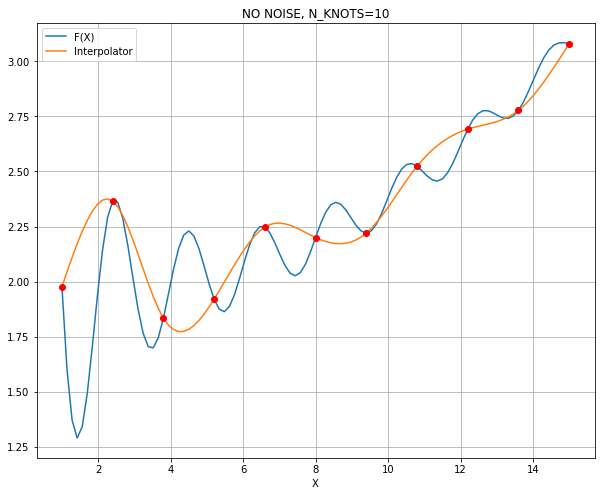

In [3]:
## протестируем работу

def fTest(x):
    return np.exp(-0.1 * x) + 1 / x * np.sin(np.pi * x) + np.exp(0.07 * x)


x0 = 1
x1 = 15
N_k = 10  # number of knots
N = N_k * 10 + 1

h = (x1 - x0) / (N - 1)
x_ = np.arange(x0, x1 + h / 2, h)
y_ = fTest(x_)

xs = x_[::int(N / N_k)]
ys = y_[::int(N / N_k)]

Spline = CubicSplineInterpolator(xs, ys)
res = Spline.Compute(x_)

plt.figure(figsize=(10, 8))
plt.grid()
plt.title('NO NOISE, N_KNOTS={0}'.format(N_k))
plt.xlabel('X')
plt.plot(x_, y_, label='F(X)')
plt.plot(x_, res, label='Interpolator')
plt.plot(xs, ys, 'ro')
plt.legend()
plt.show()

## модуль интерполяции производной

In [4]:
## возвращает интерполяцию производной

def spline_deriv(CubicSpline):
    """
    CubicSpline - Построенная интерполяция сплайнами
    """
    
    derivative_splines = []
    
    for spline in CubicSpline.coeffs:
        size = len(spline)
        new_coefs = []
        for i in range(1, size):
            new_coefs.append(i * spline[i])
        new_coefs.append(0)
        derivative_splines.append(new_coefs)
        
    new_CubicSpline = CubicSplineInterpolator(CubicSpline.xGrid, CubicSpline.fGrid)
    new_CubicSpline.coeffs = derivative_splines
    return new_CubicSpline


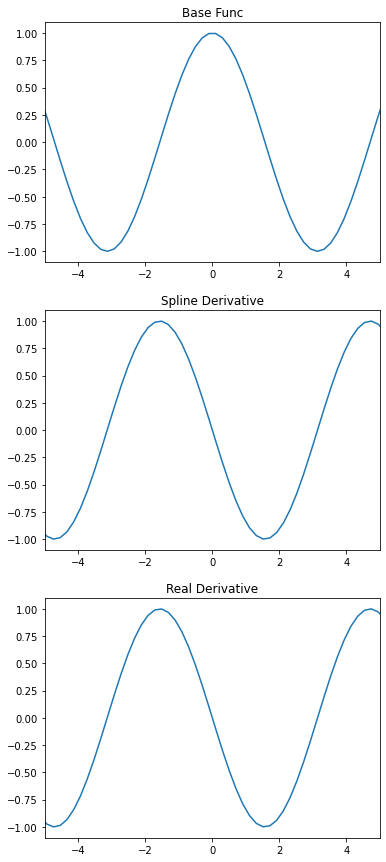

In [5]:
## Демонстрация работы

xGrid = np.linspace(-10, 10, 100)
fGrid = np.cos(xGrid)
spline = CubicSplineInterpolator(xGrid, fGrid)
deriv = spline_deriv(spline)
deriv_yGrid = deriv.Compute(xGrid)
fig, axis = plt.subplots(3, 1, figsize=(6, 15))

axis[0].plot(xGrid, fGrid)
axis[0].set_title("Base Func")
axis[0].set_xlim(-5, 5)

axis[1].plot(deriv.xGrid, deriv_yGrid)
axis[1].set_title("Spline Derivative")
axis[1].set_xlim(-5, 5)

axis[2].plot(xGrid, -np.sin(xGrid))
axis[2].set_title("Real Derivative")
axis[2].set_xlim(-5, 5)

plt.show()

## Модуль интегрирования методом симпсона

In [6]:
def simpson_method(func, n_segments, segment):
    """
    func - интегрируемая функция
    n_segments - количество делений
    segment - интервал интегрирования
    """
    
    segments = np.linspace(segment[0], segment[1], n_segments)
    sum_ = 0
    for i in range(n_segments - 1):
        sum_ += ((segments[i + 1] - segments[i]).astype(float) / 6) * \
        (func(segments[i]) + 4 * func(0.5 * (segments[i] + segments[i + 1])) + func(segments[i + 1]))\
        .astype(float)
        
    return sum_


In [7]:
f = lambda x: 3 * x ** 2 + np.sin(x) ** 2
simpson_method(f, 10, [-1, 1])

2.54534509057402

In [8]:
from scipy import integrate
integrate.quad(f, -1, 1)[0]

2.5453512865871586

## Решение задачи Коши

In [9]:
## Решение задачи Коши методом Эйлера

def cauchy_solver(funcs, start_points, tGrid):
    """
    f1 - z'(t) * integral_y^1(ro(w) dw)
    f2 - функция корреции параметра y
    x_0 - аргументы f1
    y_0 - аргументы f2
    tGrid - сетка
    """
    
    f1, f2 = funcs
    x_0, y_0 = start_points
    x = np.array([x_0])
    y = np.array([y_0])
    
    h = tGrid[1] - tGrid[0]
    fl = 0
    
    for i in range(1, len(tGrid)):
        x_prev = x[i - 1]
        y_prev = y[i - 1]
        t_prev = tGrid[i - 1]
        
        x_new = x_prev + h * f1(t_prev, y_prev)
        y_new = y_prev + h * f2(t_prev, x_prev)
        
        if y_new > 1 or y_new < 0:
            fl = 1
            break
            
        x = np.append(x, x_new)
        y = np.append(y, y_new)
        
    return x, y, tGrid, fl



## Критерии качества

In [10]:
def C1(func_x, func_y, ro, n_knots, tGrid, T):
    x_deriv_interpol = spline_deriv(func_x)
    dw = lambda w: w * ro(w)
    integral_dw = lambda t: simpson_method(func=dw, n_segments=n_knots, segment=[func_y.Compute(t), 1])
    fGrid = integral_dw(tGrid)
    integral_interpol = CubicSplineInterpolator(tGrid, fGrid)
    
    dt = lambda t: x_deriv_interpol.Compute(t) * integral_dw(t)
    integral_dt = simpson_method(func=dt, n_segments=n_knots, segment=[0, T])
    error = 1 - (integral_dt / (func_x.Compute(T) - func_x.Compute(0)))
    return error

def C2(func_x, S, T):
    return abs(func_x.Compute(T) - S(T)) / S(T)



## Оберточный класс для функции коррекции
class CorrectionFunc:
    def __init__(self, expr, b, z, S):
        self.beta = b
        self.z = z
        self.S = S
        self.form = parser.expr(expr).compile()
        
    def __call__(self, t, x):
        z = self.z(t)
        S = self.S(t)
        beta = self.beta
        return eval(self.form)

In [11]:
def search_beta(ro, z, S, cor_funcs, start_points, T, n_knots=150, auto_=False):
    """
    ro - распределение аудитории
    z - нарастающий трафик
    S - плановое значение
    cor_funcs - функции коррекции
    start_points - стартовые точеи
    T - длительность размещения
    n_knots - количество точек
    auto_ - флаг режима
    """
    
    def manual():
        print("Manual")
        odu1 = lambda t, y: z_derivative_interpol.Compute(t) * integral_interpol.Compute(y)
        F1_Grid, F2_Grid, xGrid, _ = cauchy_solver([odu1, cor_funcs], [x_0, y_0], tGrid)
        func_x = CubicSplineInterpolator(xGrid, F1_Grid)
        func_y = CubicSplineInterpolator(xGrid, F2_Grid)
        error_c1 = C1(func_x, func_y, ro, n_knots, tGrid, T)
        error_c2 = C2(func_x, S, T)
        phi = error_c1 + 10 * error_c2
        print(f"Beta = {cor_funcs.beta}")
        print(f"Ф = {phi}")
        return [(tGrid, F2_Grid, F1_Grid, x_0, y_0, cor_funcs.beta, error_c1, error_c2, phi)]
    
    def auto(x_0, y_0):
        print("Auto")
        results = []
        for cor_func in cor_funcs:

            F1_Grid, F2_Grid, xGrid, fl = cauchy_solver([odu1, cor_func], [x_0, y_0], tGrid)
            if fl: 
                continue

            func_x = CubicSplineInterpolator(xGrid, F1_Grid)
            func_y = CubicSplineInterpolator(xGrid, F2_Grid)            
            error_c1 = C1(func_x, func_y, ro, n_knots, tGrid, T)
            error_c2 = C2(func_x, S, T)
            phi = error_c1 + 10 * error_c2
            results.append(phi)
            
        results = np.array(results)
        solutions = []
        if not len(results):
            print("No beta satisfies: y in [0, 1]")
            return
        best_score = np.min(results)
        best_f = cor_funcs[np.argmin(results)]
        best_beta = best_f.beta
        print(f"Best beta = {best_beta}")
        print(f"Ф = {best_score}")
        x0_, y0_ = np.linspace(0, 5, 5), np.linspace(0, 0.5, 5)
        
        for x_0, y_0 in zip(x0_, y0_):
            F1_Grid, F2_Grid, xGrid, fl = cauchy_solver([odu1, best_f], [x_0, y_0], tGrid)
            if fl:
                continue

            func_x = CubicSplineInterpolator(xGrid, F1_Grid)
            func_y = CubicSplineInterpolator(xGrid, F2_Grid)
            error_c1 = C1(func_x, func_y, ro, n_knots, tGrid, T)
            error_c2 = C2(func_x, S, T)
            phi = error_c1 + 10 * error_c2
            solutions.append((tGrid, F2_Grid, F1_Grid, x_0, y_0, best_beta, error_c1, error_c2, phi))
            
        return solutions
        
    x_0, y_0 = start_points
    tGrid = np.linspace(0, T, n_knots)
    fGrid = np.linspace(0, 1, n_knots)
    zGrid = z(tGrid)
    z_interpol = CubicSplineInterpolator(tGrid, zGrid)
    z_derivative_interpol = spline_deriv(z_interpol)
    integral = lambda y: simpson_method(func=ro, n_segments=n_knots, segment=[y, 1])
    integralGrid = integral(tGrid)
    integral_interpol = CubicSplineInterpolator(fGrid, integralGrid)
    odu1 = lambda t, y: z_derivative_interpol.Compute(t) * integral_interpol.Compute(y)    
    
    if auto_:
        solutions = auto(x_0, y_0)
        return solutions
    else:
        solution = manual()
        return solution

In [12]:
z = lambda t: 4 * t + np.cos(t)
ro = lambda x: 6 * x * (1 - x)
S = lambda t: 3 * t + np.sin(t)
beta = 0.01
cor_funcs = CorrectionFunc("beta * (S - x)", beta, z, S)
y_0 = 0
x_0 = 0
T = 1
solutions = search_beta(ro, z, S, cor_funcs, [x_0, y_0], T, 150, auto_=False)

Manual
Beta = 0.01
Ф = 1.2766996196832687


Solution 0:
 x_0 = 0 
y_0 = 0
beta = 0.01
Loss(C1, C2) = 1.28



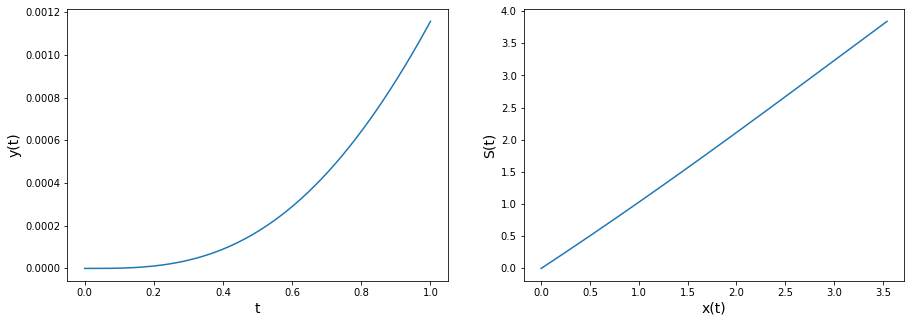

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=len(solutions), figsize=(15, 5*len(solutions)))
for i, solution in enumerate(solutions):
    tGrid, F2_Grid, F1_Grid, x_0, y_0, best_beta, error_c1, error_c2, phi = solutions[i]
    print(f"Solution {i}:\n x_0 = {x_0} \ny_0 = {y_0}\nbeta = {best_beta}\nLoss(C1, C2) = {round(phi, 2)}" + "\n")
    
    if len(solutions) != 1:
        ax[i][1].set_xlabel("x(t)", fontsize=14)
        ax[i][1].set_ylabel("S(t)", fontsize=14)
        ax[i][1].plot(F1_Grid, S(tGrid))

        ax[i][0].set_xlabel("t", fontsize=14)
        ax[i][0].set_ylabel("y(t)", fontsize=14)
        ax[i][0].plot(tGrid, F2_Grid)

    else:
        ax[1].set_xlabel("x(t)", fontsize=14)
        ax[1].set_ylabel("S(t)", fontsize=14)
        ax[1].plot(F1_Grid, S(tGrid))
        
        ax[0].set_xlabel("t", fontsize=14)
        ax[0].set_ylabel("y(t)", fontsize=14)
        ax[0].plot(tGrid, F2_Grid)

In [14]:
z = lambda t: 4 * t + np.cos(t)
ro = lambda x: 6 * x * (1 - x)
S = lambda t: 3 * t + np.sin(t)
bgrid = np.array([10 ** x for x in range(-10, 2)])
cor_funcs = [CorrectionFunc("beta * (S - x)", beta, z, S) for beta in bgrid]
y_0 = 0
x_0 = 0
T = 1
solutions = search_beta(ro, z, S, cor_funcs, [x_0, y_0], T, 150, auto_=True)

Auto
Best beta = 1e-10
Ф = 1.2766685369768773


Solution 0:
 x_0 = 0.0 
y_0 = 0.0
beta = 1e-10
Loss(C1, C2) = 1.28

Solution 1:
 x_0 = 1.25 
y_0 = 0.125
beta = 1e-10
Loss(C1, C2) = 2.58

Solution 2:
 x_0 = 2.5 
y_0 = 0.25
beta = 1e-10
Loss(C1, C2) = 4.82

Solution 3:
 x_0 = 3.75 
y_0 = 0.375
beta = 1e-10
Loss(C1, C2) = 6.64

Solution 4:
 x_0 = 5.0 
y_0 = 0.5
beta = 1e-10
Loss(C1, C2) = 8.28



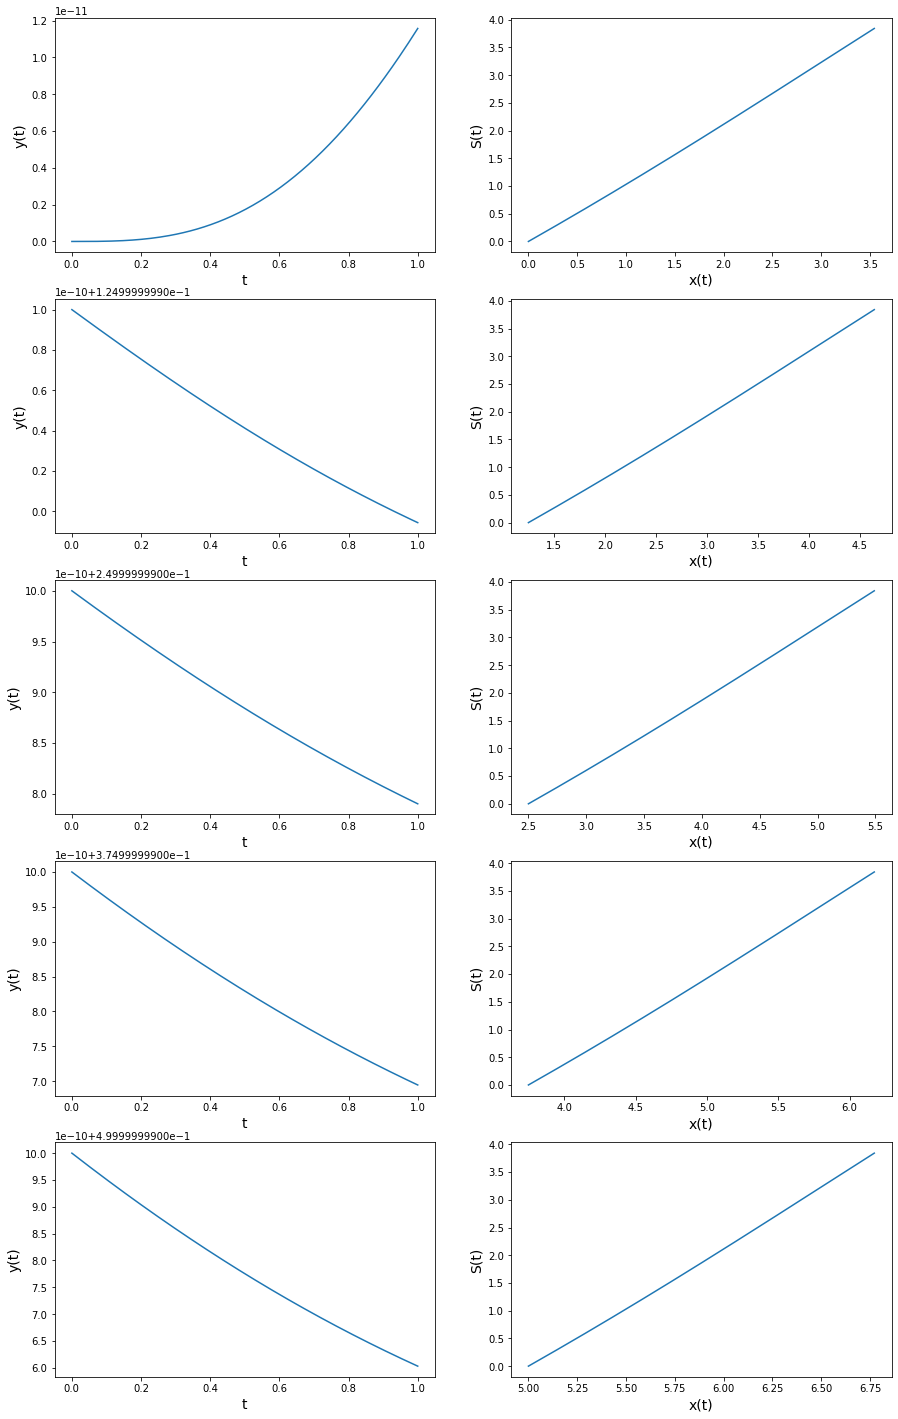

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=len(solutions), figsize=(15, 5*len(solutions)))
for i, solution in enumerate(solutions):
    tGrid, F2_Grid, F1_Grid, x_0, y_0, best_beta, error_c1, error_c2, phi = solutions[i]
    print(f"Solution {i}:\n x_0 = {x_0} \ny_0 = {y_0}\nbeta = {best_beta}\nLoss(C1, C2) = {round(phi, 2)}" + "\n")
    
    if len(solutions) != 1:
        ax[i][1].set_xlabel("x(t)", fontsize=14)
        ax[i][1].set_ylabel("S(t)", fontsize=14)
        ax[i][1].plot(F1_Grid, S(tGrid))

        ax[i][0].set_xlabel("t", fontsize=14)
        ax[i][0].set_ylabel("y(t)", fontsize=14)
        ax[i][0].plot(tGrid, F2_Grid)

    else:
        ax[1].set_xlabel("x(t)", fontsize=14)
        ax[1].set_ylabel("S(t)", fontsize=14)
        ax[1].plot(F1_Grid, S(tGrid))
        
        ax[0].set_xlabel("t", fontsize=14)
        ax[0].set_ylabel("y(t)", fontsize=14)
        ax[0].plot(tGrid, F2_Grid)